<a href="https://colab.research.google.com/github/sathika786/ECG-Classification/blob/main/ECG_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sathikaj","key":"3b4449f6702457baf4a8b756d3528934"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d shayanfazeli/heartbeat

 95% 94.0M/98.8M [00:00<00:00, 81.9MB/s]
100% 98.8M/98.8M [00:00<00:00, 107MB/s] 


In [5]:
from zipfile import ZipFile
file_name = "heartbeat.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [6]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [7]:
df_train = pd.read_csv("/content/mitbih_train.csv", header=None)
df_test = pd.read_csv("/content/mitbih_test.csv", header=None)
df_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,0.044118,0.061275,0.066176,0.061275,0.049020,0.073529,0.061275,0.061275,0.066176,0.068627,0.095588,0.075980,0.093137,0.105392,0.115196,0.102941,0.117647,0.125000,0.142157,0.127451,0.151961,0.144608,0.164216,0.144608,0.159314,0.151961,0.154412,0.142157,0.151961,0.151961,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,0.074074,0.062678,0.065527,0.065527,0.062678,0.076923,0.071225,0.082621,0.091168,0.096866,0.082621,0.082621,0.091168,0.105413,0.122507,0.148148,0.182336,0.193732,0.213675,0.207977,0.222222,0.253561,0.270655,0.287749,0.284900,0.293447,0.256410,0.247863,0.188034,0.145299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,0.056757,0.043243,0.067568,0.062162,0.078378,0.072973,0.086486,0.081081,0.108108,0.110811,0.135135,0.135135,0.170270,0.183784,0.216216,0.237838,0.270270,0.286486,0.316216,0.318919,0.332432,0.297297,0.267568,0.216216,0.189189,0.132432,0.118919,0.064865,0.064865,0.043243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,0.063536,0.082873,0.085635,0.093923,0.113260,0.124309,0.140884,0.132597,0.140884,0.091160,0.085635,0.074586,0.071823,0.080110,0.096685,0.118785,0.138122,0.140884,0.138122,0.146409,0.110497,0.102210,0.060773,0.027624,0.038674,0.013812,0.011050,0.013812,0.033149,0.005525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,0.131455,0.122066,0.140845,0.159624,0.150235,0.145540,0.136150,0.169014,0.178404,0.173709,0.183099,0.201878,0.187793,0.164319,0.187793,0.215962,0.215962,0.201878,0.211268,0.230047,0.215962,0.230047,0.239437,0.267606,0.253521,0.230047,0.220657,0.225352,0.211268,0.173709,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


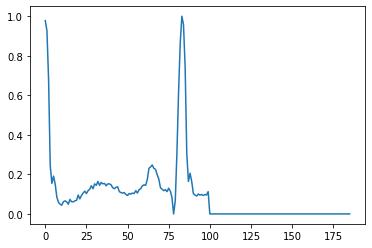

In [8]:
plt.plot(df_train.iloc[0,:186])

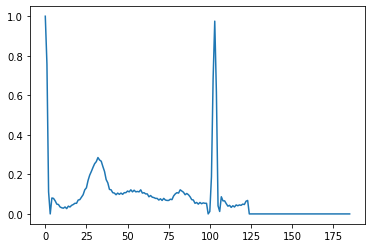

In [9]:
plt.plot(df_test.iloc[0,:186])

In [10]:
# plot the circle of value counts in dataset
def plot_equilibre(equilibre):
    plt.figure(figsize=(10,10))
    my_circle=plt.Circle( (0,0), 0.7, color='white')
    plt.pie(equilibre, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
    p=plt.gcf()
    p.gca().add_artist(my_circle)
    plt.show()

0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64


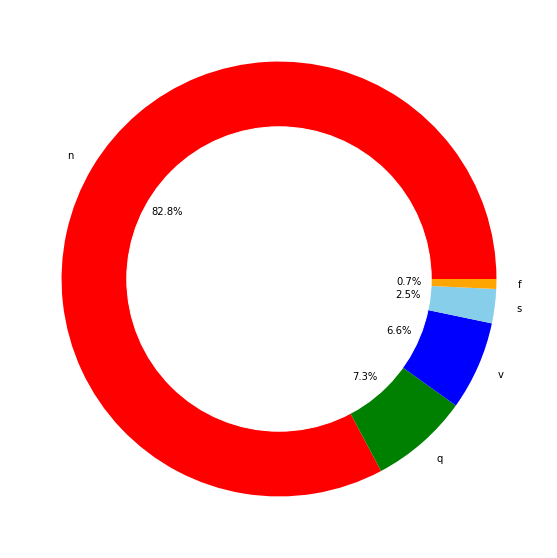

In [11]:
print(df_train[187].value_counts())

plot_equilibre(df_train[187].value_counts())

0.0    18118
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: 187, dtype: int64


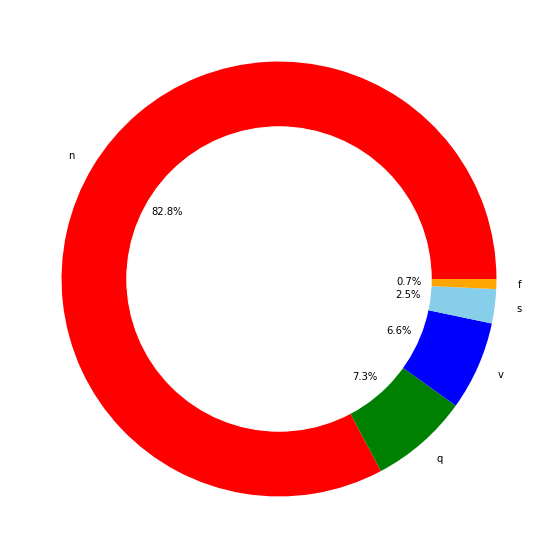

In [12]:
print(df_test[187].value_counts())

plot_equilibre(df_test[187].value_counts())

# Dataset Preparation

In [13]:
X_train = df_train.values[:, :-1]
y_train = df_train.values[:, -1].astype(int)

X_test  = df_test.values[:, :-1]
y_test  = df_test.values[:, -1].astype(int)

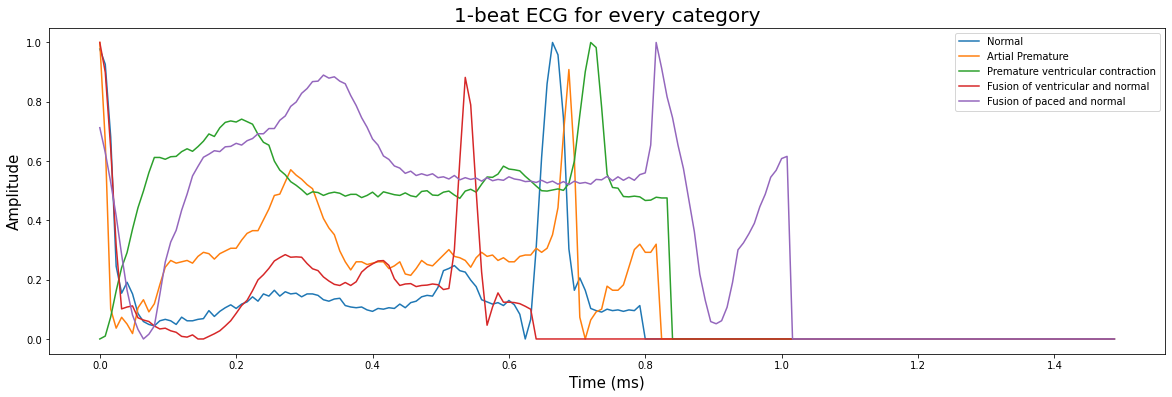

In [14]:
# plot one ECG for each category
C0 = np.argwhere(y_train == 0).flatten()
C1 = np.argwhere(y_train == 1).flatten()
C2 = np.argwhere(y_train == 2).flatten()
C3 = np.argwhere(y_train == 3).flatten()
C4 = np.argwhere(y_train == 4).flatten()

x = np.arange(0, 187)*8/1000

plt.figure(figsize=(20,6))
plt.plot(x, X_train[C0, :][0], label="Normal")
plt.plot(x, X_train[C1, :][0], label="Artial Premature")
plt.plot(x, X_train[C2, :][0], label="Premature ventricular contraction")
plt.plot(x, X_train[C3, :][0], label="Fusion of ventricular and normal")
plt.plot(x, X_train[C4, :][0], label="Fusion of paced and normal")
plt.legend()
plt.title("1-beat ECG for every category", fontsize=20)
plt.ylabel("Amplitude", fontsize=15)
plt.xlabel("Time (ms)", fontsize=15)
plt.show()

In [15]:
X_train = np.expand_dims(X_train, 2)
X_test = np.expand_dims(X_test, 2)

print(X_train.shape)
print(X_test.shape)

(87554, 187, 1)
(21892, 187, 1)


In [16]:
from tensorflow.keras import utils
y_train = utils.to_categorical(y_train)
y_test  = utils.to_categorical(y_test)

print(y_train.shape)
print(y_test.shape)

(87554, 5)
(21892, 5)


# Model Building

In [17]:
n_obs, feature, depth = X_train.shape
num_classes= 5

In [18]:
# Build Model
from tensorflow.keras import models, layers, optimizers, callbacks

inputs = layers.Input(shape=(feature,depth))
C   = layers.Conv1D(filters=32, kernel_size=5, strides=1)(inputs)

C11 = layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(C)
A11 = layers.Activation("relu")(C11)
C12 = layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A11)
S11 = layers.Add()([C12, C])
A12 = layers.Activation("relu")(S11)
M11 = layers.MaxPooling1D(pool_size=5, strides=2)(A12)


C21 = layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M11)
A21 = layers.Activation("relu")(C21)
C22 = layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A21)
S21 = layers.Add()([C22, M11])
A22 = layers.Activation("relu")(S11)
M21 = layers.MaxPooling1D(pool_size=5, strides=2)(A22)


C31 = layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M21)
A31 = layers.Activation("relu")(C31)
C32 = layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A31)
S31 = layers.Add()([C32, M21])
A32 = layers.Activation("relu")(S31)
M31 = layers.MaxPooling1D(pool_size=5, strides=2)(A32)


C41 = layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M31)
A41 = layers.Activation("relu")(C41)
C42 = layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A41)
S41 = layers.Add()([C42, M31])
A42 = layers.Activation("relu")(S41)
M41 = layers.MaxPooling1D(pool_size=5, strides=2)(A42)


C51 = layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M41)
A51 = layers.Activation("relu")(C51)
C52 = layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A51)
S51 = layers.Add()([C52, M41])
A52 = layers.Activation("relu")(S51)
M51 = layers.MaxPooling1D(pool_size=5, strides=2)(A52)

F1  = layers.Flatten()(M51)

D1  = layers.Dense(32)(F1)
A6  = layers.Activation("relu")(D1)
D2  = layers.Dense(32)(A6)

outputs = layers.Dense(num_classes, activation="softmax")(D2)

model = models.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 187, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 183, 32)      192         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 183, 32)      5152        conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 183, 32)      0           conv1d_1[0][0]                   
______________________________________________________________________________________________

In [19]:
#Compile Model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model Train

In [20]:
batch_size = 100
num_epochs = 10 

In [21]:
# Train Model
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/10
876/876 [==============================] - 85s 95ms/step - loss: 0.3342 - accuracy: 0.9034 - val_loss: 0.1136 - val_accuracy: 0.9701
Epoch 2/10
876/876 [==============================] - 82s 94ms/step - loss: 0.1013 - accuracy: 0.9718 - val_loss: 0.1022 - val_accuracy: 0.9746
Epoch 3/10
876/876 [==============================] - 82s 93ms/step - loss: 0.0756 - accuracy: 0.9787 - val_loss: 0.0720 - val_accuracy: 0.9804
Epoch 4/10
876/876 [==============================] - 82s 94ms/step - loss: 0.0614 - accuracy: 0.9823 - val_loss: 0.0818 - val_accuracy: 0.9775
Epoch 5/10
876/876 [==============================] - 83s 95ms/step - loss: 0.0579 - accuracy: 0.9831 - val_loss: 0.0631 - val_accuracy: 0.9826
Epoch 6/10
876/876 [==============================] - 84s 96ms/step - loss: 0.0493 - accuracy: 0.9851 - val_loss: 0.0610 - val_accuracy: 0.9828
Epoch 7/10
876/876 [==============================] - 84s 96ms/step - loss: 0.0429 - accuracy: 0.9873 - val_loss: 0.0649 - val_accuracy:

# Saving Model

In [22]:
# Save Model
models.save_model(model, 'ecg_arrhythmia.hdf5')

# Testing Model

In [23]:
from sklearn.metrics import classification_report, confusion_matrix

labels = ["Normal",
          "Artial Premature",
          "Premature ventricular contraction",
          "Fusion of ventricular and normal",
          "Fusion of paced and normal"]

In [24]:
# Test Model
predY = model.predict(X_test)
y_pred = np.argmax(predY,axis=1)
y_actual = np.argmax(y_test,axis=1)
cm = confusion_matrix(y_actual, y_pred)
print(cm)

[[18037    33    29    19     0]
 [  122   423    11     0     0]
 [   39     7  1379    21     2]
 [   17     0    11   134     0]
 [   21     0     5     0  1582]]


In [25]:
print(classification_report(y_actual, y_pred, target_names=labels))

                                   precision    recall  f1-score   support

                           Normal       0.99      1.00      0.99     18118
                 Artial Premature       0.91      0.76      0.83       556
Premature ventricular contraction       0.96      0.95      0.96      1448
 Fusion of ventricular and normal       0.77      0.83      0.80       162
       Fusion of paced and normal       1.00      0.98      0.99      1608

                         accuracy                           0.98     21892
                        macro avg       0.93      0.90      0.91     21892
                     weighted avg       0.98      0.98      0.98     21892

